In [1]:
# Block 1: Importing Libraries and Setting Parameters
import os
import shutil
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt
import gc
import json

# Define paths
train_dir = "/kaggle/input/facial-recognition-dataset/Training/Training"
test_dir = "/kaggle/input/facial-recognition-dataset/Testing/Testing"

# Parameters
img_size = (140, 140)
batch_size = 32
validation_split = 0.2
seed = 123

# Define the new class mapping
merge_mapping = {
    "Negative Emotion": ["Angry", "Sad", "Fear"],
    "Positive Emotion": ["Happy"],
    "Neutral": ["Neutral", "Suprise"]
}


In [2]:
# Block 2: Merging Training and Test Data into New Directories
new_data_dir = "/kaggle/working/New_Data"
os.makedirs(new_data_dir, exist_ok=True)
new_test_dir = "/kaggle/working/New_Test_Data"
os.makedirs(new_test_dir, exist_ok=True)

for new_class, old_classes in merge_mapping.items():
    os.makedirs(os.path.join(new_data_dir, new_class), exist_ok=True)
    os.makedirs(os.path.join(new_test_dir, new_class), exist_ok=True)

    for old_class in old_classes:
        for dir_type, target_dir in [(train_dir, new_data_dir), (test_dir, new_test_dir)]:
            old_class_dir = os.path.join(dir_type, old_class)
            new_class_dir = os.path.join(target_dir, new_class)

            if not os.path.exists(old_class_dir):
                continue

            for file_name in os.listdir(old_class_dir):
                shutil.copy2(os.path.join(old_class_dir, file_name), new_class_dir)

train_dir = new_data_dir
test_dir = new_test_dir

# Block 3: Computing Class Weights
new_class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in merge_mapping.keys()}
class_names = list(new_class_counts.keys())
class_indices = {name: idx for idx, name in enumerate(class_names)}
y_train = np.hstack([[class_indices[class_name]] * count for class_name, count in new_class_counts.items()])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}


In [3]:

# Block 4: Data Augmentation and Dataset Loading
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.3)
], name="data_augmentation")

def preprocess_data(image, label):
    image = tf.image.resize(image, img_size)
    image = data_augmentation(image)
    image = tf.keras.layers.Rescaling(1./127.5, offset=-1)(image)
    return image, label

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
).map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
).map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
).map(lambda x, y: (tf.keras.layers.Rescaling(1./127.5, offset=-1)(x), y)).prefetch(tf.data.AUTOTUNE)


Found 28273 files belonging to 3 classes.
Using 22619 files for training.
Found 28273 files belonging to 3 classes.
Using 5654 files for validation.
Found 7067 files belonging to 3 classes.


In [4]:
# Block 6: Building the Model
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import BayesianOptimization

def build_model(hp):
    base_model = Xception(input_shape=img_size + (3,), include_top=False, weights='imagenet')

    for layer in base_model.layers[:-80]:  # Unfreeze more layers for better fine-tuning
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.01), kernel_initializer='he_normal'),
        LeakyReLU(negative_slope=0.1),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.01), kernel_initializer='he_normal'),
        LeakyReLU(negative_slope=0.1),
        BatchNormalization(),
        Dropout(0.3),
        Dense(len(class_names), activation='softmax', kernel_initializer='he_normal', dtype='float32')
    ])

    lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
    optimizer = Adam(learning_rate=lr)
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model 


In [5]:

# Block 7: Hyperparameter Tuning
from keras_tuner.engine.hyperparameters import HyperParameters

hp = HyperParameters()
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='hyperparam_tuning',
    project_name='xception_learning_rate_bayesian'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
    callbacks=[stop_early]
)

# Get the optimal learning rate
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
optimal_lr = best_hps.get('learning_rate')
print(f"Optimal Learning Rate: {optimal_lr}")  


Trial 5 Complete [00h 09m 34s]
val_accuracy: 0.5946232676506042

Best val_accuracy So Far: 0.7345242500305176
Total elapsed time: 00h 48m 00s
Optimal Learning Rate: 0.00032966542033772056


Epoch 1/75
707/707 ━━━━━━━━━━━━━━━━━━━━ 147s 171ms/step - accuracy: 0.4761 - loss: 13.1710 - val_accuracy: 0.6335 - val_loss: 4.6452 - learning_rate: 3.2967e-04
Epoch 2/75
707/707 ━━━━━━━━━━━━━━━━━━━━ 109s 153ms/step - accuracy: 0.6216 - loss: 3.4804 - val_accuracy: 0.6470 - val_loss: 1.5597 - learning_rate: 3.2967e-04
Epoch 3/75
707/707 ━━━━━━━━━━━━━━━━━━━━ 108s 152ms/step - accuracy: 0.6650 - loss: 1.3253 - val_accuracy: 0.7147 - val_loss: 0.8971 - learning_rate: 3.2967e-04
Epoch 4/75
707/707 ━━━━━━━━━━━━━━━━━━━━ 108s 152ms/step - accuracy: 0.6851 - loss: 0.8910 - val_accuracy: 0.7152 - val_loss: 0.7651 - learning_rate: 3.2967e-04
Epoch 5/75
707/707 ━━━━━━━━━━━━━━━━━━━━ 108s 152ms/step - accuracy: 0.7100 - loss: 0.7544 - val_accuracy: 0.7312 - val_loss: 0.6962 - learning_rate: 3.2967e-04
Epoch 6/75
707/707 ━━━━━━━━━━━━━━━━━━━━ 108s 152ms/step - accuracy: 0.7177 - loss: 0.7082 - val_accuracy: 0.7351 - val_loss: 0.6908 - learning_rate: 3.2967e-04
Epoch 7/75
707/707 ━━━━━━━━━━━━━━━━━━━━

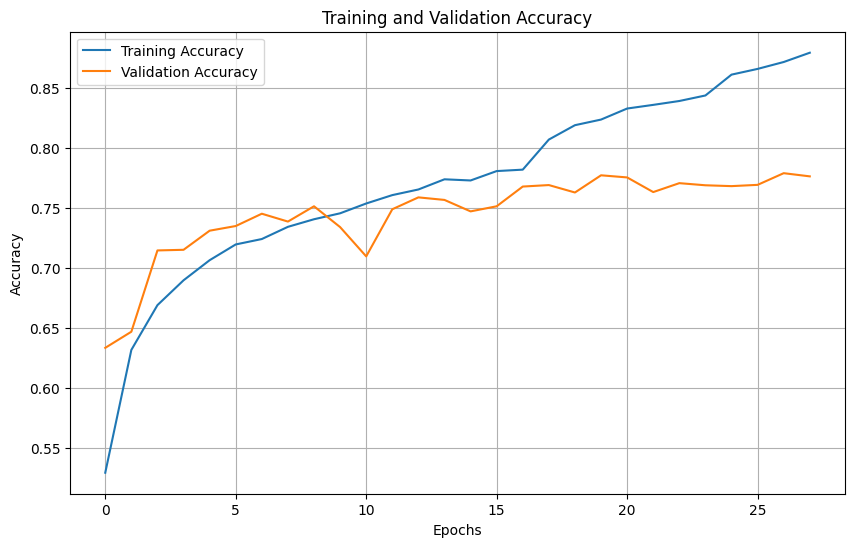

In [6]:

# Block 8: Building the Final Model
final_model = build_model(best_hps)

# Block 9: Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model_xception_new_classes.keras", save_best_only=True, monitor="val_loss")
tensorboard = TensorBoard(log_dir="logs_xception_new_classes")  

# Block 10: Training the Model
history = final_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=75,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler, checkpoint, tensorboard]
)

# Plotting Training and Validation Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show() 


221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.7877 - loss: 0.5347
Test Accuracy: 78.60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

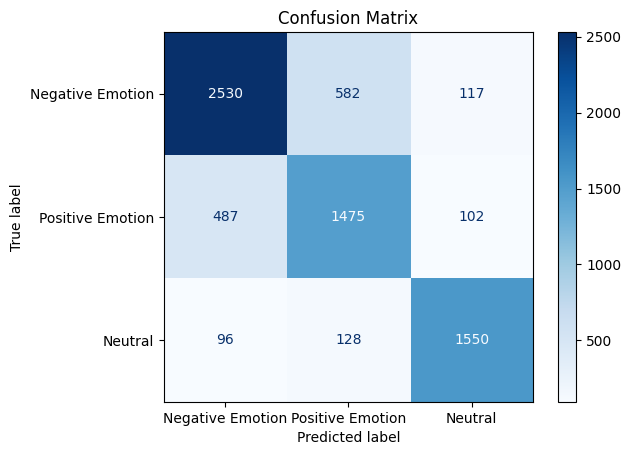


Classification Report:
                  precision    recall  f1-score   support

Negative Emotion       0.81      0.78      0.80      3229
Positive Emotion       0.68      0.71      0.69      2064
         Neutral       0.88      0.87      0.87      1774

        accuracy                           0.79      7067
       macro avg       0.79      0.79      0.79      7067
    weighted avg       0.79      0.79      0.79      7067

Model saved as 'emotion_classification_model.h5' for future use.


In [7]:

# Block 11: Evaluating the Model
final_model.load_weights("best_model_xception_new_classes.keras")
loss, accuracy = final_model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%") 

# Block 12: Generating Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    preds = final_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))

conf_matrix = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_names).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Block 13: Save the Trained Model
final_model.save("emotion_classification_model.h5")
print("Model saved as 'emotion_classification_model.h5' for future use.")
